# Statistics of random gene sets

Tong Shu Li

### Overview

Now that we have looked at the drift statistics of the GO terms with 10 to 500 genes, let's go back and examine the drift statistics of random gene sets. We would like to know how the GO term results (which are based on prior knowledge) compare to results we could potentially obtain without prior knowledge (e.g. through a genetic algorithm).

To do so, we will need to examine what the results are like if we generated gene sets from the data through random sampling. This will allow us to benchmark our results and determine if they are significant.

### Questions to answer

1. What is the effect of gene set size?

2. What is the likelihood of a random gene set to significantly drift?

3. What is the distribution of parameter estimates and p-values?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from mpl_toolkits.mplot3d import Axes3D

In [2]:
sys.path.append("../..")

In [3]:
from src.util import load_json

In [4]:
%matplotlib inline

---

## Read gene set composition

Read the gene sets we pre-generated.

In [5]:
gene_sets = load_json("../../data/PMID26623667/rand_sampling/genesets/uniform.json")

## Read random model information

The fitted models have already been pre-calculated.

In [6]:
raw_res = pd.read_csv("../../data/PMID26623667/rand_sampling/models/uniform.model", sep = '\t')

In [7]:
raw_res.shape

(687400, 10)

In [8]:
raw_res.head()

,parameter,estimate,std_error,t_value,p_value,adj_rsq,anova_pvalue,interaction,model,uid
0,(Intercept),0.227157,0.062948,3.608653,0.002168,0.751647,0.090149,False,linear,unif_gset_size100_num0
1,day_harvested,0.072748,0.009934,7.323433,0.000001,0.751647,0.090149,False,linear,unif_gset_size100_num0
2,drugmianserin,-0.259661,0.067281,-3.859355,0.001258,0.751647,0.090149,False,linear,unif_gset_size100_num0
3,(Intercept),0.166643,0.068003,2.450522,0.026145,0.780711,0.090149,True,linear,unif_gset_size100_num0
4,day_harvested,0.085487,0.011706,7.303170,0.000002,0.780711,0.090149,True,linear,unif_gset_size100_num0


In [9]:
raw_res["uid"].nunique()

49100

---

## Explore log linear models with no interaction term

For now, we will only examine the log-linear models with no interaction term, since this model type fit the complete transcriptome the best.

In [10]:
logres = (raw_res
    .query("model == 'loglinear' & ~interaction")
    .assign(nlog_pval = lambda df: -np.log(df["p_value"]))
)

In [11]:
logres.shape

(147300, 11)

In [12]:
logres.head()

,parameter,estimate,std_error,t_value,p_value,adj_rsq,anova_pvalue,interaction,model,uid,nlog_pval
7,(Intercept),0.141068,0.052918,2.665762,1.629754e-02,0.855238,0.523516,False,loglinear,unif_gset_size100_num0,4.116741
8,drugmianserin,-0.306131,0.052305,-5.852779,1.919317e-05,0.855238,0.523516,False,loglinear,unif_gset_size100_num0,10.860956
9,log(day_harvested),0.344579,0.033760,10.206735,1.146109e-08,0.855238,0.523516,False,loglinear,unif_gset_size100_num0,18.284308
21,(Intercept),0.173827,0.033727,5.153949,7.950403e-05,0.953454,0.063358,False,loglinear,unif_gset_size100_num1,9.439703
22,drugmianserin,-0.426736,0.033336,-12.800984,3.721533e-10,0.953454,0.063358,False,loglinear,unif_gset_size100_num1,21.711715


---

## Exploratory analysis

We reshape the data for easier plotting.

In [13]:
log_day = (logres
    .query("parameter == 'log(day_harvested)'")
    [["uid", "estimate", "p_value", "nlog_pval"]]
    .rename(
        columns = {
            "estimate": "log_day_est",
            "nlog_pval": "log_day_nlp",
            "p_value": "log_day_pval"
        }
    )
)

mian = (logres
    .query("parameter == 'drugmianserin'")
    [["uid", "estimate", "p_value", "nlog_pval"]]
    .rename(
        columns = {
            "estimate": "mian_est",
            "nlog_pval": "mian_nlp",
            "p_value": "mian_pval"
        }
    )
)

In [14]:
info = (pd
    .DataFrame(
        [(uid, len(genes)) for uid, genes in gene_sets.items()],
        columns = ["uid", "num_genes"]
    )
    .sort_values("uid")
    .merge(
        logres[["uid", "adj_rsq", "anova_pvalue"]].drop_duplicates(),
        how = "inner", on = "uid"
    )
    .merge(log_day, how = "inner", on = "uid")
    .merge(mian, how = "inner", on = "uid")
)

In [15]:
info.shape

(49100, 10)

In [16]:
info.head()

,uid,num_genes,adj_rsq,anova_pvalue,log_day_est,log_day_pval,log_day_nlp,mian_est,mian_pval,mian_nlp
0,unif_gset_size100_num0,100,0.855238,0.523516,0.344579,1.146109e-08,18.284308,-0.306131,1.919317e-05,10.860956
1,unif_gset_size100_num1,100,0.953454,0.063358,0.387548,1.644799e-12,27.133403,-0.426736,3.721533e-10,21.711715
2,unif_gset_size100_num10,100,0.915581,0.300346,0.246432,1.690587e-10,22.500775,-0.245652,1.210832e-07,15.926788
3,unif_gset_size100_num11,100,0.925145,0.169018,0.434465,6.682597e-11,23.428929,-0.443704,3.700896e-08,17.112106
4,unif_gset_size100_num12,100,0.830617,0.632639,0.256052,3.637429e-08,17.129404,-0.210074,1.111321e-04,9.104791


---

## Adjusted R squared vs geneset size

The most important parameter to consider is the size of the gene set in question. It determines how many primers we would have to make for sequencing, so we would prefer to keep it as low as possible unless there was a compelling reason to increase the gene set size.

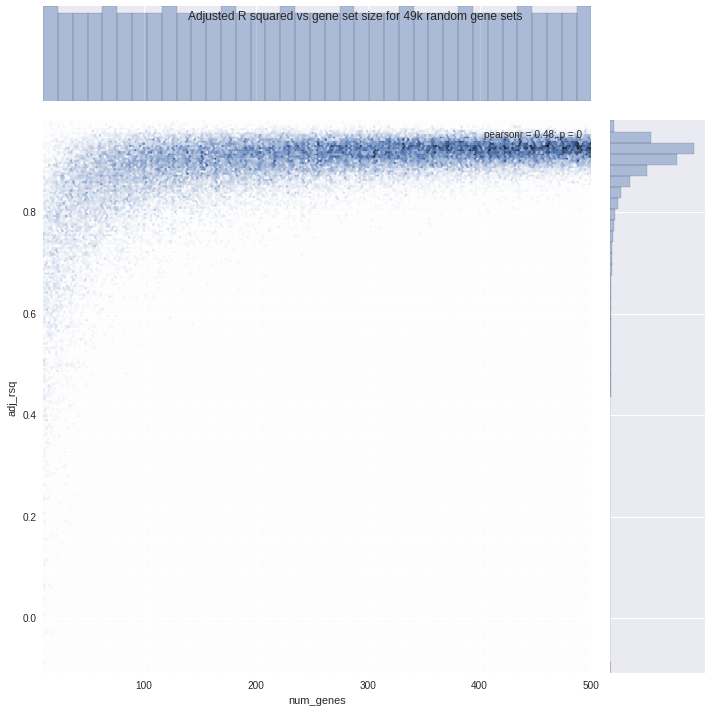

In [17]:
g = sns.jointplot(
    data = info, x = "num_genes", y = "adj_rsq",
    kind = "hex", size = 10
)

g.fig.suptitle("Adjusted R squared vs gene set size for 49k random gene sets", fontsize = 12);

With this hex plot we observe a similar distribution as what was seen with the GO term analysis. As the size of the gene set increases, the mean adjusted R-squared value increases until it approaches roughly 0.9. The distribution of R-squareds also narrows as the gene set size increases, meaning gene sets are much more likely to have high R-squared values by chance.

This means that we should not be surprised to find large gene sets with high R-squared values, since we would expect that any random gene set of that size would give a similar result.

As for why R-squared increases with size, I believe it means that the model is better representing the entire transcriptome as a whole.

## ANOVA p-value

The ANOVA p-value determines whether the interaction term between time and treatment is significant. We found for the GO terms that the distribution was relatively uniform.

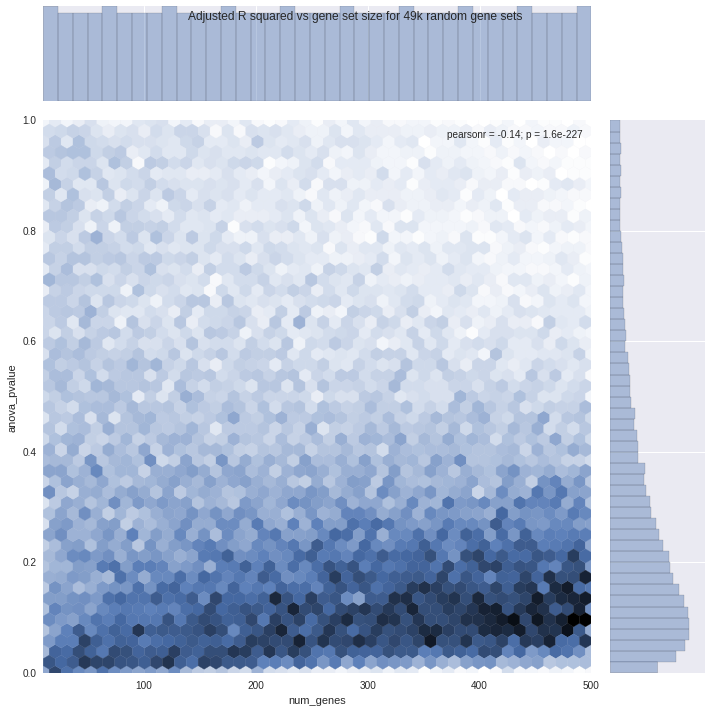

In [18]:
g = sns.jointplot(
    data = info, x = "num_genes", y = "anova_pvalue",
    kind = "hex", size = 10
)

g.fig.suptitle("Adjusted R squared vs gene set size for 49k random gene sets", fontsize = 12);

The ANOVA p-value distribution looks very strange. The peak density does not occur near zero, but rather at ~0.1. Based on the hexplot, it seems that the ANOVA p-value distribution starts out uniform for small gene sets, and shifts to become more distributed near 0.1 as the gene set size increases. Overall the trend is quite confusing, but I think the fact that the distribution is relatively uniform for small (< 100 genes) gene sets is the main take away, since we will not want to create large gene sets for sequencing anyways.

## P-value distribution for time and treatment variables

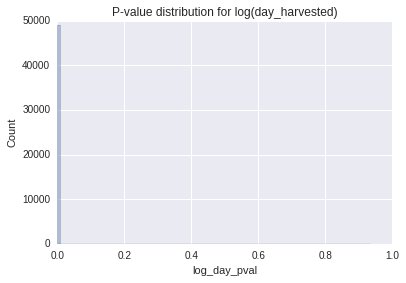

In [19]:
ax = sns.distplot(
    info["log_day_pval"],
    kde = False, bins = 100
)

ax.set_ylabel("Count")
ax.set_title("P-value distribution for log(day_harvested)");

If we stratify for gene set size:

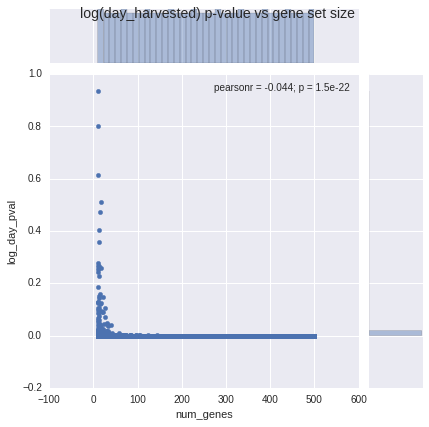

In [20]:
g = sns.jointplot(
    data = info,
    x = "num_genes", y = "log_day_pval",
    kind = "scatter"
)

g.fig.suptitle("log(day_harvested) p-value vs gene set size", fontsize = 14);

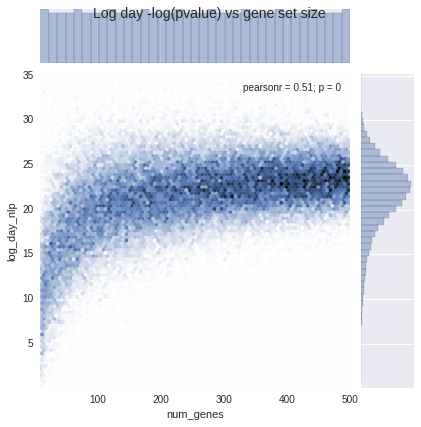

In [21]:
g = sns.jointplot(
    data = info,
    x = "num_genes", y = "log_day_nlp",
    kind = "hex"
)

g.fig.suptitle("Log day -log(pvalue) vs gene set size", fontsize = 14);

The p-value for whether the effect of time on drift is significant increases as the size of the gene set increases. Again, this means that any random gene set, once sufficiently large, will give significant results in this dataset.

### Effect of mianserin

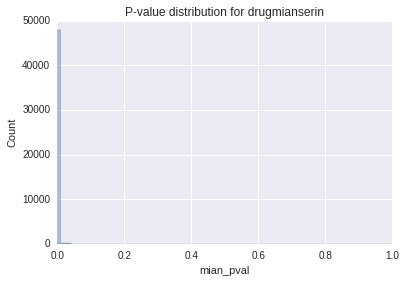

In [22]:
ax = sns.distplot(
    info["mian_pval"],
    kde = False, bins = 100
)

ax.set_ylabel("Count")
ax.set_title("P-value distribution for drugmianserin");

We see the same thing with mianserin: all gene sets have significant estimates.

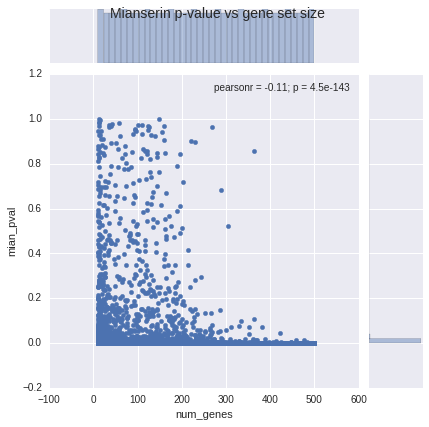

In [23]:
g = sns.jointplot(
    data = info,
    x = "num_genes", y = "mian_pval",
    kind = "scatter"
)

g.fig.suptitle("Mianserin p-value vs gene set size", fontsize = 14);

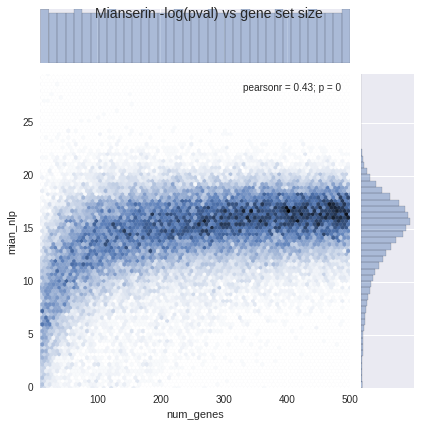

In [24]:
g = sns.jointplot(
    data = info,
    x = "num_genes", y = "mian_nlp",
    kind = "hex"
)

g.fig.suptitle("Mianserin -log(pval) vs gene set size", fontsize = 14);

In a random sampling of gene sets, every gene set had significant p-values for the two variables by chance. This means that the coefficients are always non-zero by chance. Therefore we will need to compare the results of a gene set to the background random distribution.

---

## Volcano plots

We compare the estimate of the coefficient with the significance of the estimate.

### Log(day_harvested)

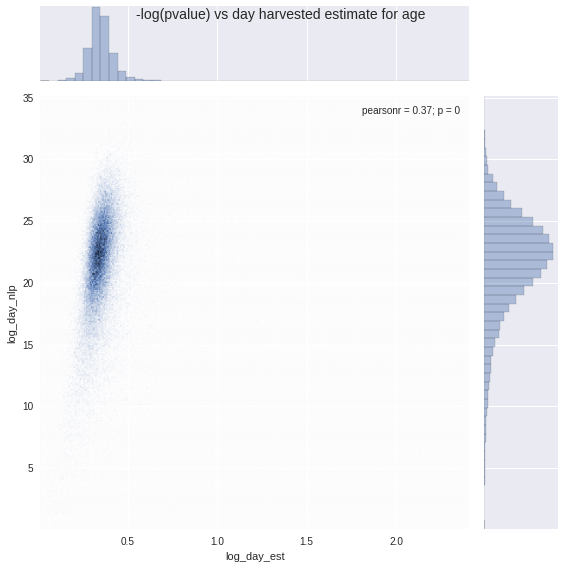

In [25]:
g = sns.jointplot(
    data = info,
    x = "log_day_est", y = "log_day_nlp",
    kind = "hex", size = 8
)

g.fig.suptitle("-log(pvalue) vs day harvested estimate for age", fontsize = 14);

From the 2D plot we can see that the coefficient estimate for time is always positive, meaning the drift increased for all random gene sets over time.

#### Stratify by gene set size:

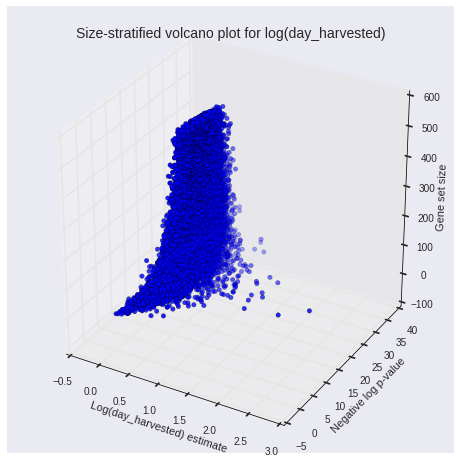

In [26]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(info["log_day_est"], info["log_day_nlp"], info["num_genes"])

ax.set_xlabel('Log(day_harvested) estimate')
ax.set_ylabel('Negative log p-value')
ax.set_zlabel('Gene set size')

ax.set_title("Size-stratified volcano plot for log(day_harvested)", fontsize = 14)

plt.show()

From the 3D plot we can see again that the variation in both the estimate and p value decreases as the gene set size increases. Again this means that random gene sets are expected to give significant results, and that a specific GO term fits well is therefore not surprising.

### Mianserin volcano plots

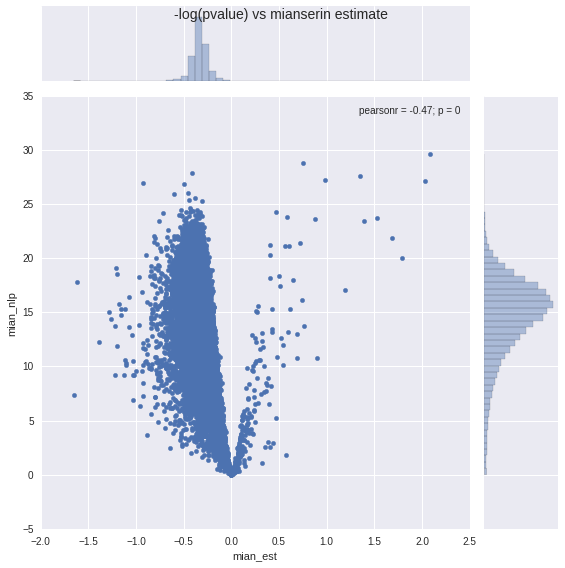

In [27]:
g = sns.jointplot(
    data = info,
    x = "mian_est", y = "mian_nlp",
    kind = "scatter", size = 8
)

g.fig.suptitle("-log(pvalue) vs mianserin estimate", fontsize = 14);

There are more gene sets with positive mianserin estimates than what we observed with the GO terms. However, most have negative estimates, as we saw in the GO term analysis.

#### Replot with density

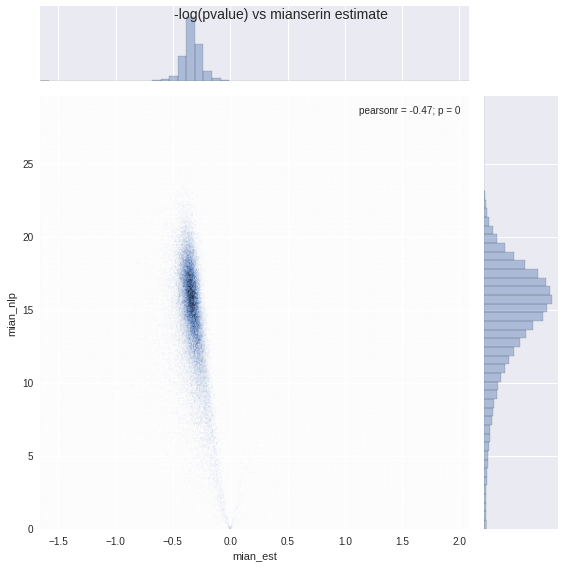

In [28]:
g = sns.jointplot(
    data = info,
    x = "mian_est", y = "mian_nlp",
    kind = "hex", size = 8
)

g.fig.suptitle("-log(pvalue) vs mianserin estimate", fontsize = 14);

### Stratify by gene set size:

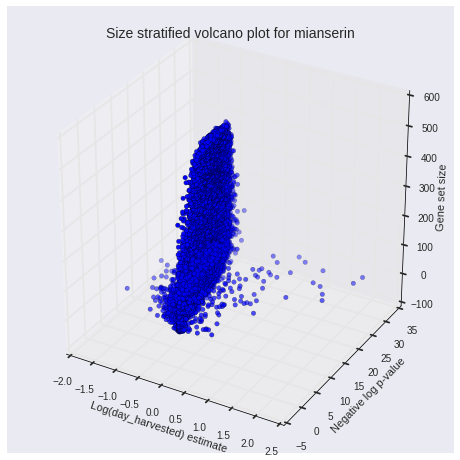

In [29]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(info["mian_est"], info["mian_nlp"], info["num_genes"])

ax.set_xlabel('Log(day_harvested) estimate')
ax.set_ylabel('Negative log p-value')
ax.set_zlabel('Gene set size')

ax.set_title("Size stratified volcano plot for mianserin", fontsize = 14)

plt.show()

When stratified by size, we again see that the positive estimate outliers are the result of small gene sets. As the gene set size increases, the chance that the estimate is positive decreases significantly.

## Conclusion

In this dataset, larger gene sets are more likely to give significant results by random chance. The adjusted R-squared of the model increases dramatically as the gene set size increases. In addition, the variability of the coefficient estimates and p values decreases as the gene set size increases.

In some sense it seems that the random sampling results are trying to estimate the parameters for the entire transcriptome.

It would be interesting to know whether this trend is also true for other drifting datasets.